# Test Code

## Group 29

1. Aizhigit MUSSALI (56006183)
2. Ralif RAKHMATULLIN(55836666)
3. Zhanaidar MUKANOV (55574846)

In [1]:
import os
import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models import resnet50
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score

In [2]:
class DeepFakeDataset(Dataset):
    def __init__(self, imgs, transforms = None):
        super().__init__()
        self.imgs = imgs
        self.transforms = transforms
        
    def __getitem__(self, idx):
        image_name = self.imgs[idx]
        img = Image.open(image_name)
        if "original" in image_name: label = 1 # it is original
        else: label = 0 # it is fake
        label = torch.tensor(label, dtype = torch.float32)
        img = self.transforms(img)
        return img, label
    
    def __len__(self):
        return len(self.imgs)

In [3]:
def make_dataloader(data_path):
    original_imgs = glob.glob(f"{data_path}/original/*")
    fake_imgs = glob.glob(f"{data_path}/manipulated/*")
    original_imgs.extend(fake_imgs)
    imgs = original_imgs
    dataset = DeepFakeDataset(imgs, T.Compose([
            T.ToTensor(),
            T.Normalize((0, 0, 0),(1, 1, 1))
        ]))
    dataloader = DataLoader(dataset = dataset, batch_size = 16, shuffle = True)
    return dataloader

In [4]:
def test(model_path, data_path):
    Accuracy, Recall, Precision, AUC = 0, 0, 0, 0
    
    model = resnet50(pretrained = True)
    model.fc = nn.Sequential(nn.Linear(2048, 1, bias = True), nn.Sigmoid())
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    global_model = model
    
    preds_list = []
    labels_list = []

    dataloader = make_dataloader(data_path)
    for imgs, labels in dataloader:
        labels.reshape((labels.shape[0], 1))
        preds = model(imgs)
        preds_list.extend(preds.tolist())
        labels_list.extend(labels.tolist())
    
    labels_list = np.array(labels_list)
    preds_list = np.array(preds_list)
    preds_list = preds_list > 0.5
    print(preds_list)
    print(labels_list)
    global global_preds
    global_preds = preds_list
    global global_labels
    global_labels = labels_list
    print(len(global_preds))
    print(len(global_labels))
    Accuracy = accuracy_score(labels_list, preds_list)
    Recall = recall_score(labels_list, preds_list)
    Precision = precision_score(labels_list, preds_list)
    AUC = roc_auc_score(labels_list, preds_list)
    return Accuracy, Recall, Precision, AUC

In [5]:
result = test("./resnet50.pth", "./data/test")

[[False]
 [False]
 [False]
 ...
 [ True]
 [False]
 [False]]
[0. 0. 0. ... 1. 0. 0.]
1505
1505


In [6]:
print(f"Accuracy: {result[0]}")
print(f"Recall: {result[1]}")
print(f"Precision: {result[2]}")
print(f"AUC: {result[3]}")

Accuracy: 0.8272425249169435
Recall: 0.576
Precision: 0.8571428571428571
AUC: 0.7641194029850746


### Confusion Matrix

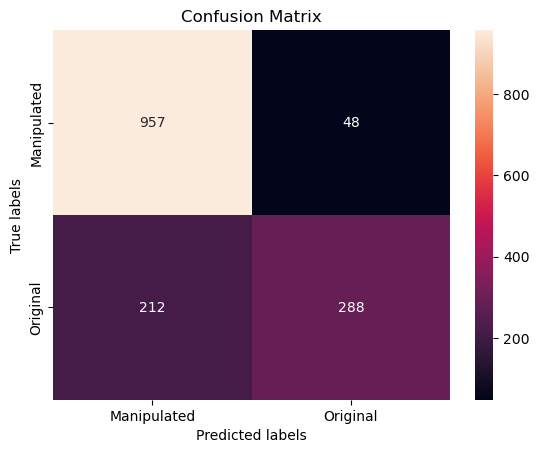

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(global_labels, global_preds)  
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Manipulated', 'Original']); ax.yaxis.set_ticklabels(['Manipulated', 'Original']);